In [9]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import unicodedata

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# I - Read Data 

In [2]:
global_df = pd.read_csv('datasets/global_df.csv')

,id,user_id,created_at,cooked,post_number,updated_at,reply_count,reply_to_post_number,quote_count,incoming_link_count,...,noHTML_text,lemma_LDA_text,no_sw_LDA_text,token_NN_text,creation_date,creation_year,number_of_words,date_time,date_year,date_month
0,6997.0,884,2016-03-14 17:40:17.744000+00:00,<p>The size of the mask plus electronics is ra...,3.0,2016-03-14 17:40:42.276000+00:00,1.0,2.0,0.0,10.0,...,The size of the mask plus electronics is rath...,mask electronics material mask sweat issue str...,mask electronics material mask sweat issue str...,"['mask', 'electronics', 'material', 'mask', 's...",2016-03-14,2016,63,2016-03-14,2016,2016-03
1,3798.0,884,2014-02-24 22:58:11+00:00,"<aside class=""quote no-group quote-modified"" d...",4.0,2015-10-21 04:24:48.934000+00:00,0.0,NaN,1.0,0.0,...,\n \n \n Agaricus: \n \n For “restedness” I...,agaricus restedness point scale cover range fo...,agaricus restedness point scale cover range fo...,"['agaricus', 'restedness', 'point', 'scale', '...",2014-02-24,2014,144,2014-02-24,2014,2014-02
2,8586.0,884,2016-11-05 13:46:33.686000+00:00,"<p>The <a href=""https://biostrap.com"">Biostrap...",15.0,2016-11-05 13:47:19.301000+00:00,1.0,NaN,0.0,20.0,...,The Biostrap looks promising (and is shippi...,biostrap claim offer hr ppg sensor hrv rest re...,biostrap claim offer hr ppg sensor hrv rest re...,"['biostrap', 'claim', 'offer', 'hr', 'ppg', 's...",2016-11-05,2016,96,2016-11-05,2016,2016-11
3,7124.0,884,2016-04-14 13:50:17.159000+00:00,"<p>I’ve <a href=""http://www.quantifiedbob.com/...",1.0,2016-04-14 13:50:17.159000+00:00,0.0,NaN,0.0,878.0,...,I’ve posted a lengthy writeup of my recent e...,experience diet study cell metabolism institut...,experience diet study cell metabolism institut...,"['experience', 'diet', 'study', 'cell', 'metab...",2016-04-14,2016,216,2016-04-14,2016,2016-04
4,8707.0,884,2016-11-15 18:36:40.786000+00:00,"<p>Personally, I want to be able to access tim...",6.0,2016-11-15 18:36:40.786000+00:00,1.0,NaN,0.0,4.0,...,"Personally, I want to be able to access time ...",access series data breath tempo second second ...,access series data breath tempo second second ...,"['access', 'series', 'data', 'breath', 'tempo'...",2016-11-15,2016,34,2016-11-15,2016,2016-11


In [3]:
global_df = global_df.iloc[global_df.astype(str).drop_duplicates().index]

In [4]:
# getting rows with topic/post content

global_df = global_df[global_df.cooked != '0']

(10282, 53)

### Clean Text

In [5]:
# Remove html code <p>
def remove_html(text):
    pattern = re.compile('<[^<]+?>')
    text = re.sub(pattern, ' ', text)
    return text

In [6]:
global_df['noHTML_text'] = global_df.cooked.apply(lambda x: remove_html(x))

In [7]:
# Function to clean text

def clean_text(text):
    
    # Remove html code <p>
    pattern = re.compile('<[^<]+?>')
    text = re.sub(pattern, ' ', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/\S+','',text)
    
    # lowercase
    text =text.lower()
    

    # Remove ticks, apostrophes and letters after " 's "
    text = re.sub("\’\w+", '', text)
    text = re.sub("\'\w+", '', text)
    
    
    # Remove all types of nums
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = re.sub(r"\b\d+\b", ' ', text)
    
    # Remove specific punctuations
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    # Remove accents "é"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # remove the hashtag symbol #
    text = re.sub(r'#','',text)
   # text = re.sub(r'[-./]', ' ', text)
    
    return text

In [10]:
global_df['cleaned_text'] = global_df.cooked.apply(lambda x: clean_text(x))

# Compare between Original Text & Clean Text

pd.options.display.max_colwidth = 300
global_df[['cooked', 'cleaned_text']].head(1)

,cooked,cleaned_text
0,"<p>The size of the mask plus electronics is rather bulky and the foam material on the underside of the mask sometimes makes my forehead sweat so I’m guessing the slippage issue/waking me up is being caused by this.</p>\n<p>The mask has an elastic strap, but unfortunately it’s non-adjustable. I’m...",the size of the mask plus electronics is rather bulky and the foam material on the underside of the mask sometimes makes my forehead sweat so i guessing the slippage issue waking me up is being caused by this the mask has an elastic strap but unfortunately it non adjustable i thinking about cut...


In [11]:
df = global_df.groupby(['topic_id'], as_index = False).agg({'cleaned_text': ' '.join})

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df.cleaned_text.values.tolist()))

print(data_words[:1])

[['replace', 'this', 'first', 'paragraph', 'with', 'short', 'description', 'of', 'your', 'new', 'category', 'this', 'guidance', 'will', 'appear', 'in', 'the', 'category', 'selection', 'area', 'so', 'try', 'to', 'keep', 'it', 'below', 'characters', 'until', 'you', 'edit', 'this', 'text', 'or', 'create', 'topics', 'this', 'category', 'won', 'appear', 'on', 'the', 'categories', 'page', 'use', 'the', 'following', 'paragraphs', 'for', 'longer', 'description', 'as', 'well', 'as', 'to', 'establish', 'any', 'category', 'guidelines', 'or', 'rules', 'some', 'things', 'to', 'consider', 'in', 'any', 'discussion', 'replies', 'below', 'what', 'is', 'this', 'category', 'for', 'why', 'should', 'people', 'select', 'this', 'category', 'for', 'their', 'topic', 'how', 'is', 'this', 'different', 'than', 'the', 'other', 'categories', 'we', 'already', 'have', 'do', 'we', 'need', 'this', 'category', 'should', 'we', 'merge', 'this', 'with', 'another', 'category', 'or', 'split', 'it', 'into', 'more', 'categorie

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['replace', 'this', 'first', 'paragraph', 'with', 'short', 'description', 'of', 'your', 'new', 'category', 'this', 'guidance', 'will', 'appear', 'in', 'the', 'category', 'selection', 'area', 'so', 'try', 'to', 'keep', 'it', 'below', 'characters', 'until', 'you', 'edit', 'this', 'text', 'or', 'create', 'topics', 'this', 'category', 'won', 'appear', 'on', 'the', 'categories', 'page', 'use', 'the', 'following', 'paragraphs', 'for', 'longer', 'description', 'as', 'well', 'as', 'to', 'establish', 'any', 'category', 'guidelines', 'or', 'rules', 'some', 'things', 'to', 'consider', 'in', 'any', 'discussion', 'replies', 'below', 'what', 'is', 'this', 'category', 'for', 'why', 'should', 'people', 'select', 'this', 'category', 'for', 'their', 'topic', 'how', 'is', 'this', 'different', 'than', 'the', 'other', 'categories', 'we', 'already', 'have', 'do', 'we', 'need', 'this', 'category', 'should', 'we', 'merge', 'this', 'with', 'another', 'category', 'or', 'split', 'it', 'into', 'more', 'categories

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['replace', 'short', 'description', 'new', 'category', 'guidance', 'appear', 'category', 'selection', 'area', 'try', 'keep', 'character', 'edit', 'text', 'create', 'topic', 'category', 'appear', 'category', 'page', 'use', 'follow', 'paragraph', 'long', 'description', 'well', 'establish', 'category', 'guideline', 'rule', 'thing', 'consider', 'discussion', 'reply', 'category', 'people', 'select', 'category', 'topic', 'different', 'category', 'already', 'need', 'category', 'merge', 'category', 'split', 'category']]


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 11), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1)]]


In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=3)

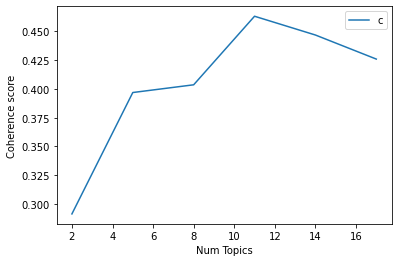

In [33]:
# Show graph
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
coherence_values

[0.4595551357973616,
 0.4595551357973616,
 0.4595551357973616,
 0.4595551357973616,
 0.4595551357973616,
 0.4595551357973616]

In [34]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2912
Num Topics = 5  has Coherence Value of 0.3969
Num Topics = 8  has Coherence Value of 0.4036
Num Topics = 11  has Coherence Value of 0.4633
Num Topics = 14  has Coherence Value of 0.4469
Num Topics = 17  has Coherence Value of 0.426


In [42]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.005*"psychomotor_vigilance" + 0.003*"pvt" + 0.000*"router" + '
  '0.000*"attentional" + 0.000*"dial" + 0.000*"setback" + 0.000*"moodscope" + '
  '0.000*"digital_stimulation" + 0.000*"karaoke" + 0.000*"camping"'),
 (1,
  '0.049*"management" + 0.043*"revenue" + 0.024*"remote" + 0.022*"ad" + '
  '0.014*"utility" + 0.012*"operation" + 0.011*"scratch" + 0.011*"biomedical" '
  '+ 0.011*"generous" + 0.011*"budget"'),
 (2,
  '0.249*"sleep" + 0.051*"night" + 0.037*"bed" + 0.022*"deep" + 0.019*"wake" + '
  '0.018*"hour" + 0.015*"quality" + 0.011*"oura" + 0.010*"stage" + '
  '0.009*"light"'),
 (3,
  '0.019*"self" + 0.018*"health" + 0.016*"thank" + 0.015*"research" + '
  '0.015*"people" + 0.012*"would" + 0.012*"personal" + 0.011*"question" + '
  '0.011*"study" + 0.011*"interested"'),
 (4,
  '0.024*"wash" + 0.020*"inspiration" + 0.012*"selection" + 0.009*"root" + '
  '0.005*"blend" + 0.001*"proteus" + 0.000*"housemate" + 0.000*"ventilate" + '
  '0.000*"regulalrly" + 0.000*"splash"'),
 (5,

In [41]:
vis_data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word,mds='mmds')
pyLDAvis.display(vis_data)

/Users/bastian/anaconda3/envs/qf-forums/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
